In [1]:
! pip install transformers

In [2]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from transformers import BertModel, TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from transformers import AutoTokenizer

Load dataset

In [5]:
!wget https://zenodo.org/record/4561253/files/WELFake_Dataset.csv

--2023-11-25 09:25:20--  https://zenodo.org/record/4561253/files/WELFake_Dataset.csv
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/4561253/files/WELFake_Dataset.csv [following]
--2023-11-25 09:25:20--  https://zenodo.org/records/4561253/files/WELFake_Dataset.csv
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 245086152 (234M) [text/plain]
Saving to: ‘WELFake_Dataset.csv’

WELFake_Dataset.csv 100%[===================>] 233.73M  65.4MB/s    in 5.9s    

2023-11-25 09:25:27 (39.5 MB/s) - ‘WELFake_Dataset.csv’ saved [245086152/245086152]



In [6]:
data=pd.read_csv("./WELFake_Dataset.csv")


Data Analysis

In [7]:
data.head(10)

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,1
7,7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,1
8,8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1
9,9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1


In [8]:
data.dropna(subset = ['text', 'title'], inplace = True)
data['text'] = data['title'] + ' ' + data['text']

X = data['text']
y = data['label']

In [9]:
data['num_words'] = data['text'].apply(lambda x: len(x.split()))


Text(0.5, 1.0, 'Distribution of Fake - 0 /Real - 1 News')

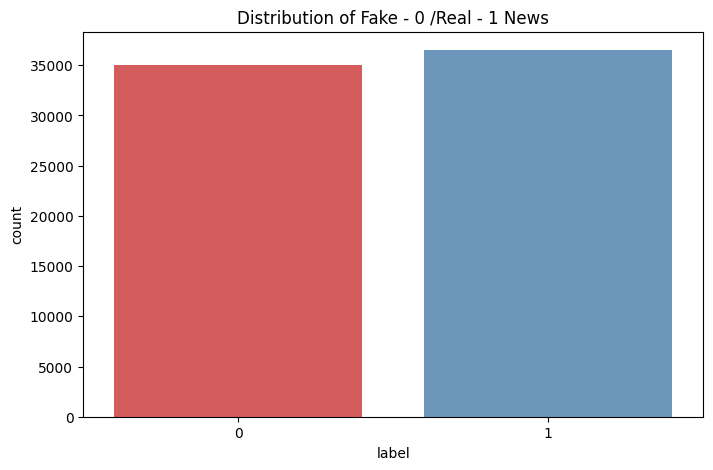

In [10]:
plt.figure(figsize = (8,5))
sns.countplot(x = data['label'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of Fake - 0 /Real - 1 News')

<ipython-input-11-e1101d5804c3>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data['num_words'], bins = range(1, 3000, 50), palette = 'Set1', alpha = 0.8)


Text(0.5, 1.0, 'Distribution of Words count')

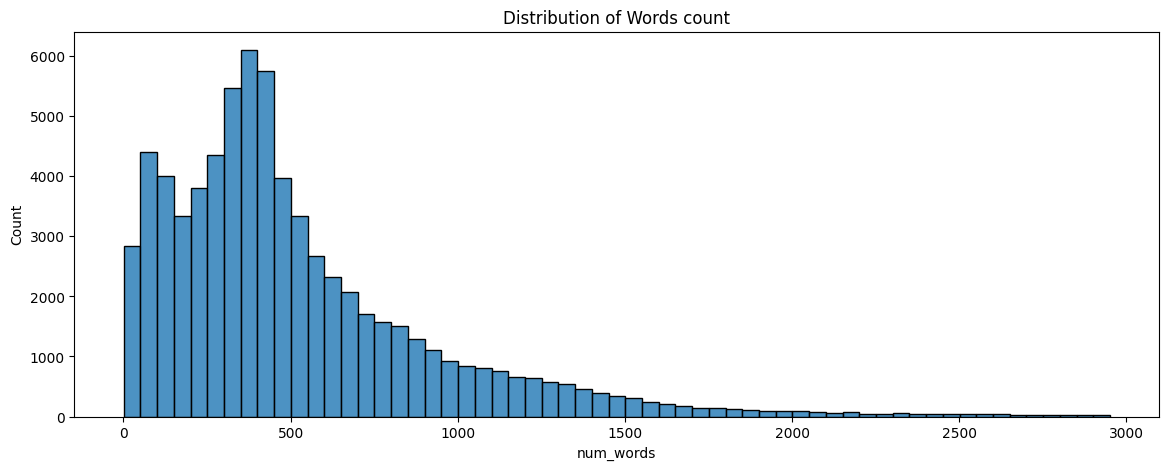

In [11]:
plt.figure(figsize = (14,5))
sns.histplot(data['num_words'], bins = range(1, 3000, 50), palette = 'Set1', alpha = 0.8)
plt.title('Distribution of Words count')

In [12]:
data.label.value_counts()

1    36509
0    35028
Name: label, dtype: int64

In [13]:
print("sample text:",data.text[36709])
print("label: ",data.label[36709])

sample text: Mattis says U.S. military policy in Syria unchanged WASHINGTON (Reuters) - U.S. Defense Secretary Jim Mattis said on Tuesday that the United States’ military policy in Syria had not changed and remains focused on defeating Islamic State militants even after the United States launched 59 cruise missiles at a Syrian airfield last week.  “The goal right now in Syria, and the military campaign is focused on accomplishing that, is breaking ISIS, destroying ISIS in Syria,” Mattis said at a Pentagon press briefing, using an acronym for Islamic State. He added that there was no doubt that the Syrian government was responsible for a poison gas attack and it had used chemical weapons several times in the past.  
label:  0


In [14]:
max_len=100
data_text=data["text"]
data_label=data["label"]


In [15]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [17]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)

In [19]:
def tokenize(X):

    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [20]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

In [21]:
maxlen=100

create bert model

In [22]:
def create_model():
    dropout_rate=0.2
    input_ids=Input(shape=(maxlen,),dtype=tf.int32)
    input_mask=Input(shape=(maxlen,),dtype=tf.int32)
    bert_layer=bert_model([input_ids,input_mask])[1]
    x=Dropout(0.5)(bert_layer)
    x=Dense(128,activation="relu")(x)
    x=Dropout(0.3)(x)
    x=Dense(1,activation="sigmoid")(x)
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model



In [23]:
model=create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 100, 7                                           
                             68),                                                             

# Train model

In [24]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-05,
    decay_steps=10000,
    decay_rate=0.9)

In [25]:
optimizer = Adam(learning_rate=lr_schedule, epsilon=1e-08,clipnorm=1.0)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=50,baseline=0.4,min_delta=0.0001,restore_best_weights=False)

In [28]:
history = model.fit(x = {'input_1':X_train_token['input_ids'],'input_2':X_train_token['attention_mask']}, y = Y_train, epochs=3, validation_split = 0.2, batch_size = 100, callbacks=[callback])

Epoch 1/3
458/458 [==============================] - 937s 2s/step - loss: 0.0408 - accuracy: 0.9859 - val_loss: 0.0332 - val_accuracy: 0.9888
Epoch 2/3
458/458 [==============================] - 942s 2s/step - loss: 0.0230 - accuracy: 0.9917 - val_loss: 0.0302 - val_accuracy: 0.9899
Epoch 3/3
458/458 [==============================] - 941s 2s/step - loss: 0.0145 - accuracy: 0.9951 - val_loss: 0.0290 - val_accuracy: 0.9905


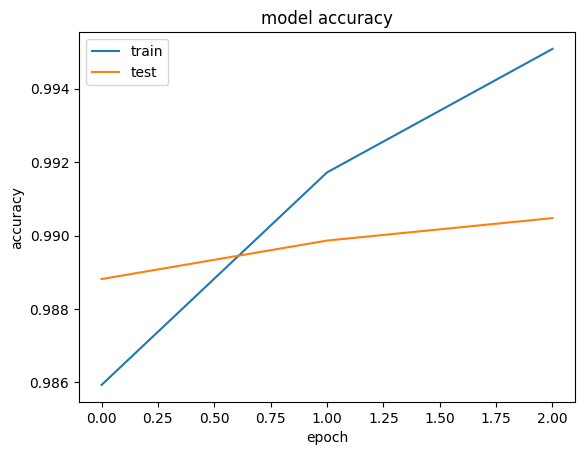

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

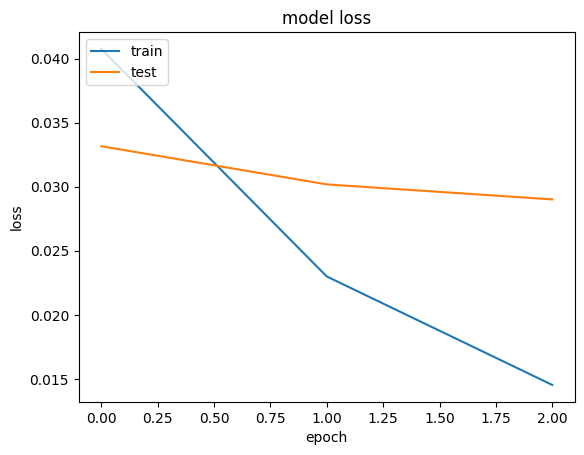

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [31]:
y_pred = np.where(model.predict({ 'input_1' : X_test_token['input_ids'] , 'input_2' : X_test_token['attention_mask']}) >=0.5,1,0)

448/448 [==============================] - 100s 216ms/step


Confusion matrix

Text(70.72222222222221, 0.5, 'Real Labels')

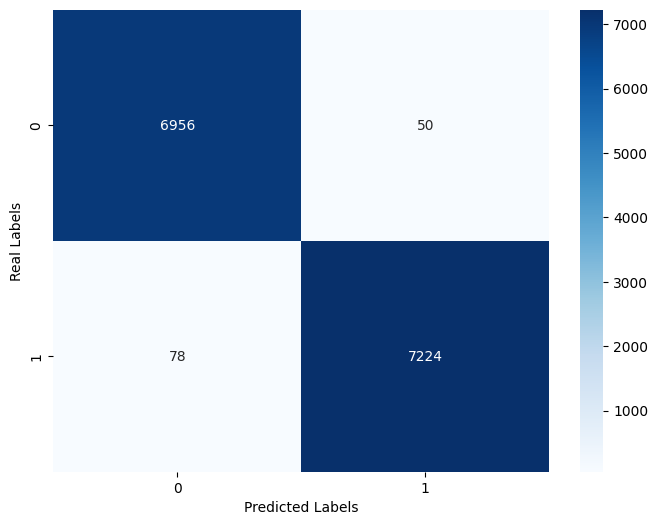

In [35]:
#plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(Y_test,y_pred), annot=True,
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

In [36]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7006
           1       0.99      0.99      0.99      7302

    accuracy                           0.99     14308
   macro avg       0.99      0.99      0.99     14308
weighted avg       0.99      0.99      0.99     14308



Custom data prediction

In [40]:
test_text="US President Donald Trump has arrived in Vietnam ahead of his second summit with North Korean leader, Kim Jong-un. Air Force One landed at Hanoi's Noi Bai airport hours after Mr Kim reached the Vietnamese capital by train and car.The summit, which is due to take place on Wednesday and Thursday, follows a historic first round of talks in Singapore last year.The two leaders are expected to discuss progress towards ridding the Korean peninsula of nuclear weapons."

In [41]:
test_token = tokenize(test_text)
test_text_pred = np.where(model.predict({ 'input_1' : test_token['input_ids'] , 'input_2' : test_token['attention_mask']}) >=0.5,1,0)
if(test_text_pred[0]==0):
    print("Fake news")
else:
    print("Real news")

15/15 [==============================] - 3s 217ms/step
Real news


In [42]:
#save the model
model.save('fake_news_bert.h5')
model.save_weights("fake_news_bert_weights")



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
